# Backpropagation Practice

Implement a 3 input, 4 node hidden-layer, 1 output node Multilayer Perceptron on the following dataset:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 0  | 0  | 1  | 0 |
| 0  | 1  | 1  | 1 |
| 1  | 0  | 1  | 1 |
| 0  | 1  | 0  | 1 |
| 1  | 0  | 0  | 1 |
| 1  | 1  | 1  | 0 |
| 0  | 0  | 0  | 0 |

If you look at the data you'll notice that the first two columns behave like an XOR gate while the last column is mostly just noise. Remember that creating an XOR gate was what the perceptron was criticized for not being able to learn. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
X = np.array([[0,0,1,1], 
               [0,1,1,1], 
               [1,0,1,1], 
               [0,1,0,1],
               [1,0,0,1],
               [1,1,1,1],
               [0,0,0,1]
              ])
y = np.array([[0],[1],[1],[1],[1],[0],[0]])

In [12]:
##### Your Code Here #####

class Neural_Network(object):
  def __init__(self):
    self.inputs = 4
    self.hiddenNodes = 4
    self.outputNodes = 1

    # Initialize Weights:
    self.L1_weights = np.random.randn(self.inputs, self.hiddenNodes) # (3x2)
    self.L2_weights = np.random.randn(self.hiddenNodes, self.outputNodes) # (3x1)

  def feed_forward(self, X):
    
    # Weighted sum between inputs and hidden layer:
    self.hidden_sum = np.dot(X, self.L1_weights)
    
    # Activations of weighted sum:
    self.activated_hidden = self.sigmoid(self.hidden_sum)
    
    # Weighted sum between hidden and output:
    self.output_sum = np.dot(self.activated_hidden, self.L2_weights)
    
    # final activation of output:
    self.activated_output = self.sigmoid(self.output_sum)
    
    return self.activated_output
    
  def sigmoid(self, s):
    return 1/(1+np.exp(-s))
  
  #sigmoid derivative  
  def sigmoidPrime(self, s):
    return s * (1 - s)
  
 #dCost/dWeights =    
    
  def backward(self, X, y, output):
    # backward propgate through the network
    
    # error in output:
    self.output_error = y - output 
    
    # applying derivative of sigmoid to error:
    self.output_delta = self.output_error * self.sigmoidPrime(output) 
    
    # z2 error: how much our hidden layer weights contributed to output error:
    self.z2_error = self.output_delta.dot(self.L2_weights.T)
    
    # applying derivative of sigmoid to z2 error:
    self.z2_delta = self.z2_error*self.sigmoidPrime(self.activated_hidden) 
    
    # adjusting first set (input --> hidden) weights:
    self.L1_weights += X.T.dot(self.z2_delta) 
    
    # adjusting second set (hidden --> output) weights:
    self.L2_weights += self.activated_hidden.T.dot(self.output_delta) 
    
  def train (self, X, y):
    output = self.feed_forward(X)
    self.backward(X, y, output)
    
NN = Neural_Network()
for i in range(1000): # trains the NN 1,000 times
  if i+1 in [1,2,3,4,5] or (i+1) % 50 == 0:
    print('+---------- EPOCH', i+1, '-----------+')
    print("Input: \n", X) 
    print("Actual Output: \n", y)  
    print("Predicted Output: \n" + str(NN.feed_forward(X))) 
    print("Loss: \n" + str(np.mean(np.square(y - NN.feed_forward(X))))) # mean sum squared loss
    print("\n")
  NN.train(X, y)

#Introducing bias 1 helped to descrease the error from 0.24 to 0.00075

+---------- EPOCH 1 -----------+
Input: 
 [[0 0 1 1]
 [0 1 1 1]
 [1 0 1 1]
 [0 1 0 1]
 [1 0 0 1]
 [1 1 1 1]
 [0 0 0 1]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
[[0.38437549]
 [0.43509213]
 [0.37539768]
 [0.46105702]
 [0.39715178]
 [0.42380196]
 [0.40795155]]
Loss: 
0.26527307768567193


+---------- EPOCH 2 -----------+
Input: 
 [[0 0 1 1]
 [0 1 1 1]
 [1 0 1 1]
 [0 1 0 1]
 [1 0 0 1]
 [1 1 1 1]
 [0 0 0 1]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
[[0.44750743]
 [0.48544965]
 [0.46547912]
 [0.53085521]
 [0.5104323 ]
 [0.50198359]
 [0.49330093]]
Loss: 
0.24369203247795088


+---------- EPOCH 3 -----------+
Input: 
 [[0 0 1 1]
 [0 1 1 1]
 [1 0 1 1]
 [0 1 0 1]
 [1 0 0 1]
 [1 1 1 1]
 [0 0 0 1]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
[[0.47943535]
 [0.5114311 ]
 [0.51435195]
 [0.56944445]
 [0.57327779]
 [0.54427825]
 [0.53970182]]
Loss: 
0.23705695155234988


+---------- EPOCH 4 -----------+
Input: 

## Try building/training a more complex MLP on a bigger dataset.

Use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) to build the cannonical handwriting digit recognizer and see what kind of accuracy you can achieve. 

If you need inspiration, the internet is chalk-full of tutorials, but I want you to see how far you can get on your own first. I've linked to the original MNIST dataset above but it will probably be easier to download data through a neural network library. If you reference outside resources make sure you understand every line of code that you're using from other sources, and share with your fellow students helpful resources that you find.


In [14]:
##### Your Code Here #####
from mlxtend.data import mnist_data
X, y = mnist_data()

print('Dimensions: %s x %s' % (X.shape[0], X.shape[1]))
print('1st row', X[0])

Dimensions: 5000 x 784
1st row [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  51. 159. 253. 159.  50.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  48. 238. 252. 252. 252. 237.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  54.
 227. 253. 252. 239. 233. 252.  57.   6.   0. 

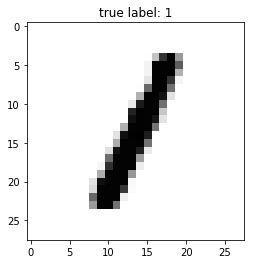

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_digit(X, y, idx):
    img = X[idx].reshape(28,28)
    plt.imshow(img, cmap='Greys',  interpolation='nearest')
    plt.title('true label: %d' % y[idx])
    plt.show()
plot_digit(X, y, 600)       

In [24]:
#using tensorflow
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

11493376/11490434 [==============================] - 3s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
60000/60000 [==============================] - 22s 373us/sample - loss: 0.2201 - acc: 0.9349
Epoch 2/5
60000/60000 [==============================] - 21s 354us/sample - loss: 0.0962 - acc: 0.9703
Epoch 3/5
60000/60000 [==============================] - 19s 322us/sample - loss: 0.0699 - acc: 0.9777
Epoch 4/5
60000/60000 [==============================] - 19s 321us/sample - loss: 0.0544 - acc: 0.9829
Epoch 5/5
10000/10000 [==============================] - 1s 97us/sample - loss: 0.0657 - acc: 0.9804


[0.06570803621758241, 0.9804]

## Stretch Goals: 

- Implement Cross Validation model evaluation on your MNIST implementation 
- Research different [Gradient Descent Based Optimizers](https://keras.io/optimizers/)
 - [Siraj Raval the evolution of gradient descent](https://www.youtube.com/watch?v=nhqo0u1a6fw)
- Build a housing price estimation model using a neural network. How does its accuracy compare with the regression models that we fit earlier on in class?